In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold,
                                     cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate,
                                     RepeatedStratifiedKFold)
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import missingno as msno

from imblearn.over_sampling import ADASYN

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)


# Heart Failure Prediction

This project focuses on predicting heart failure using machine learning techniques applied to clinical records data. It involves preprocessing the data, including handling missing values and categorical features, building pipelines for various classification algorithms such as Logistic Regression, Random Forest, SVM, XGBoost, and KNN. Techniques like SMOTE oversampling are used to address class imbalance, and cross-validation is applied for robust model evaluation. Model performance is evaluated using metrics like accuracy, F1-score, and learning curves, with the goal of identifying the most effective predictive models for heart failure.

## Raw Data Collection. Analysis of the Data

This part of the code reads the dataset from a CSV file containing clinical records of heart failure patients. 

The 'time' column, which is not relevant to the analysis and could introduce noise, is dropped from the DataFrame. The feature matrix X is created by excluding the target column ('DEATH_EVENT') and the 'time' column, while the target vector y is defined as the 'DEATH_EVENT' column. This preprocessing step ensures that irrelevant data is removed before further analysis and modeling.

In [2]:
path_file = "heart_failure_clinical_records_dataset.csv"
df = pd.read_csv(path_file)

df.drop(columns=['time'], inplace=True)

X = df.drop(columns=['DEATH_EVENT'])  # Exclude target column and 'time' column
y = df['DEATH_EVENT']

## Missing Data Handling

This step calculates the percentage of missing values for each column in the dataset. The resulting percentages indicate the proportion of missing values in each column. In our case, there are no missing values, as all percentages are zero.

In [3]:
missing_percentage = df.isnull().sum(axis=0) / df.shape[0]
print(missing_percentage)

age                         0.0
anaemia                     0.0
creatinine_phosphokinase    0.0
diabetes                    0.0
ejection_fraction           0.0
high_blood_pressure         0.0
platelets                   0.0
serum_creatinine            0.0
serum_sodium                0.0
sex                         0.0
smoking                     0.0
DEATH_EVENT                 0.0
dtype: float64


We can go further with our investigation and verify that there's actually no missing values in our dataset. This step of selecting rows where at least one value is missing serves as further investigation and verification that there are no missing values in the dataset.

In [4]:
rows_with_nan = df[df.isna().any(axis=1)]
rows_with_nan

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT


The correlation matrix shows the relationships between different features in our dataset. Each cell represents the correlation coefficient between two features. A value close to 1 indicates a strong positive correlation, while a value close to -1 indicates a strong negative correlation. Values close to 0 suggest little to no linear relationship. This matrix helps identify potential associations between features in our dataset, aiding in understanding how they influence each other.

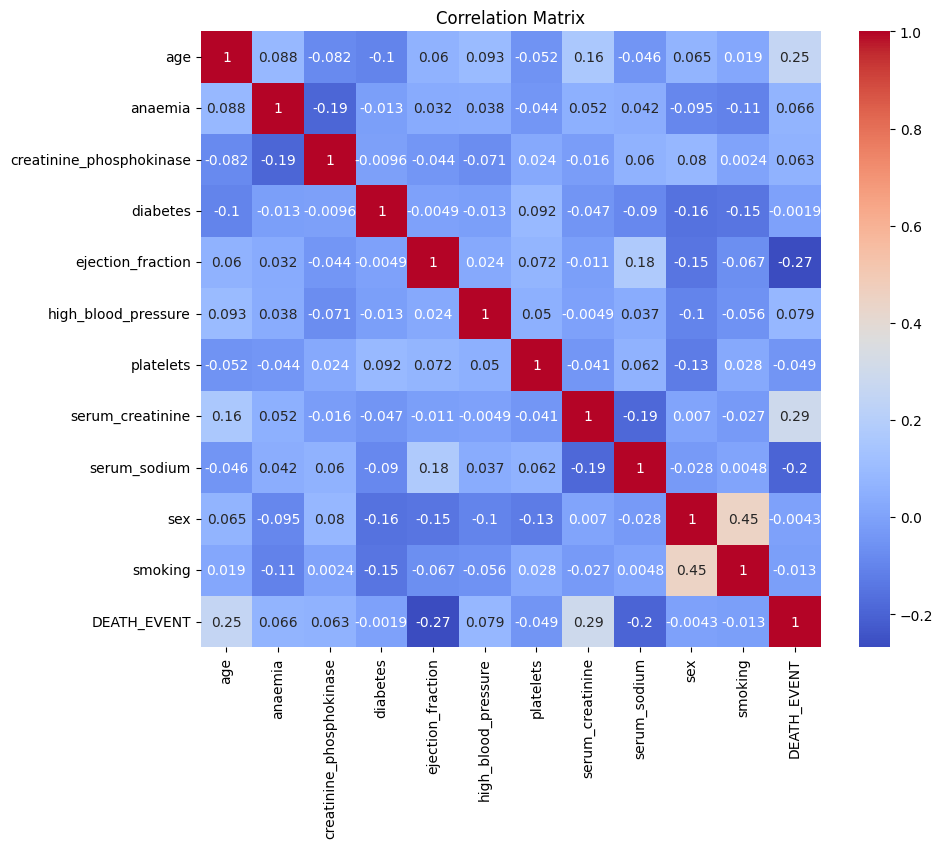

<Figure size 1000x800 with 0 Axes>

In [5]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()


This code allows us to visualize the distribution of each feature in the dataset. By plotting histograms, we can observe the frequency distribution of numerical values for each feature.

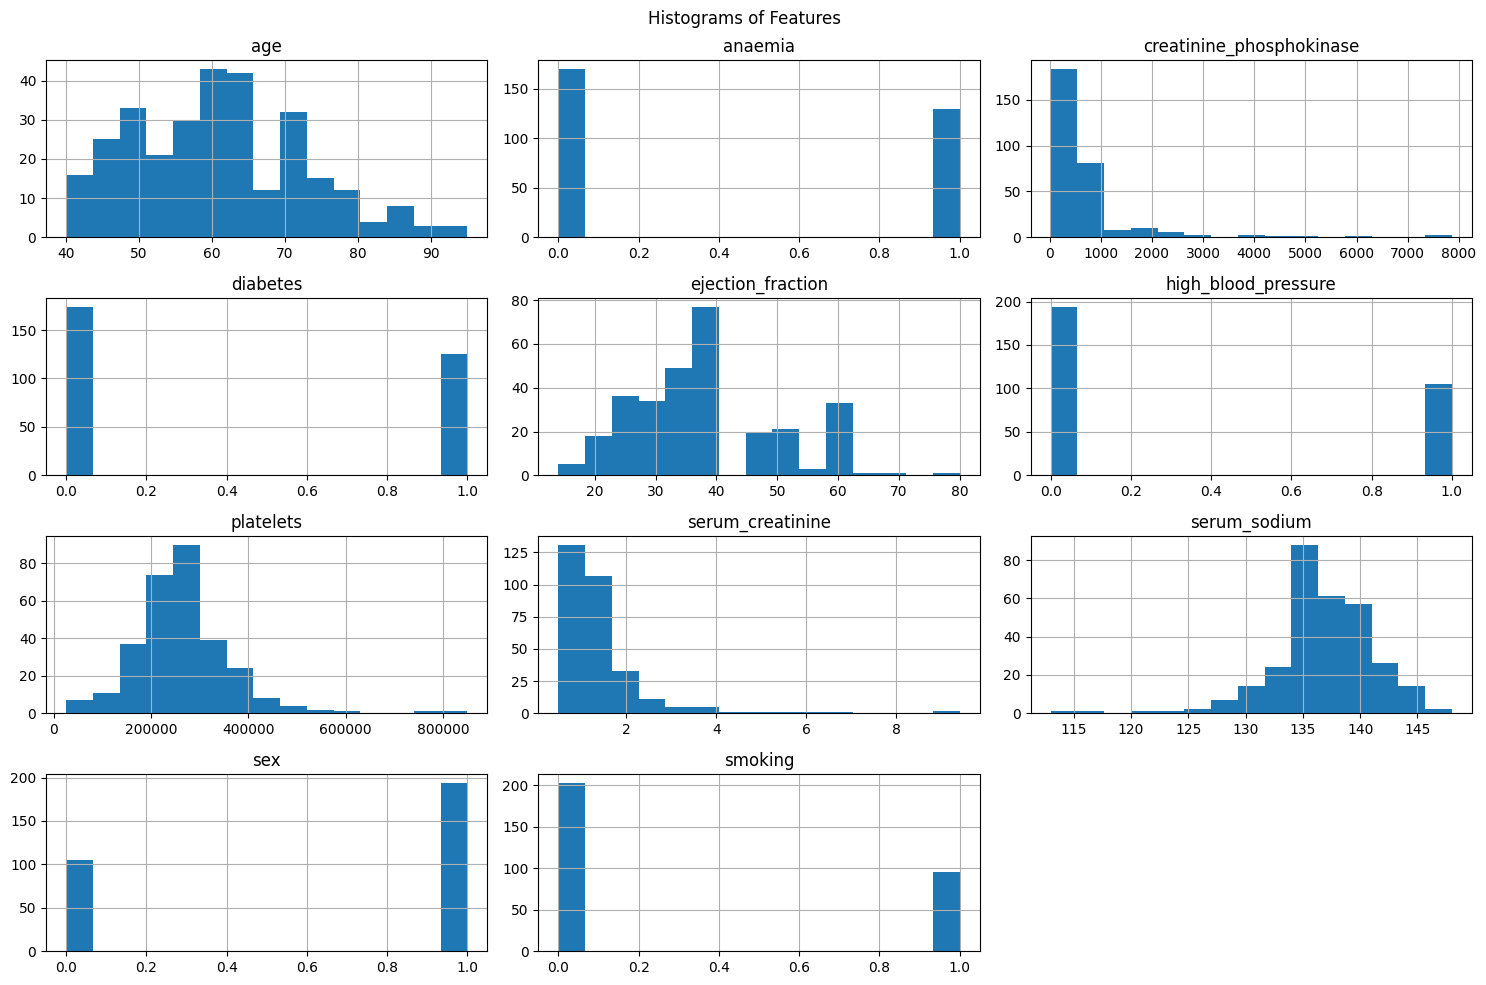

In [6]:
df.drop('DEATH_EVENT', axis=1).hist(bins=15, figsize=(15, 10), layout=(4, 3))
plt.suptitle('Histograms of Features')
plt.tight_layout()
plt.show()

Box Plots: These plots are excellent for visualizing the distribution of the data in relation to the target variable and identifying outliers.

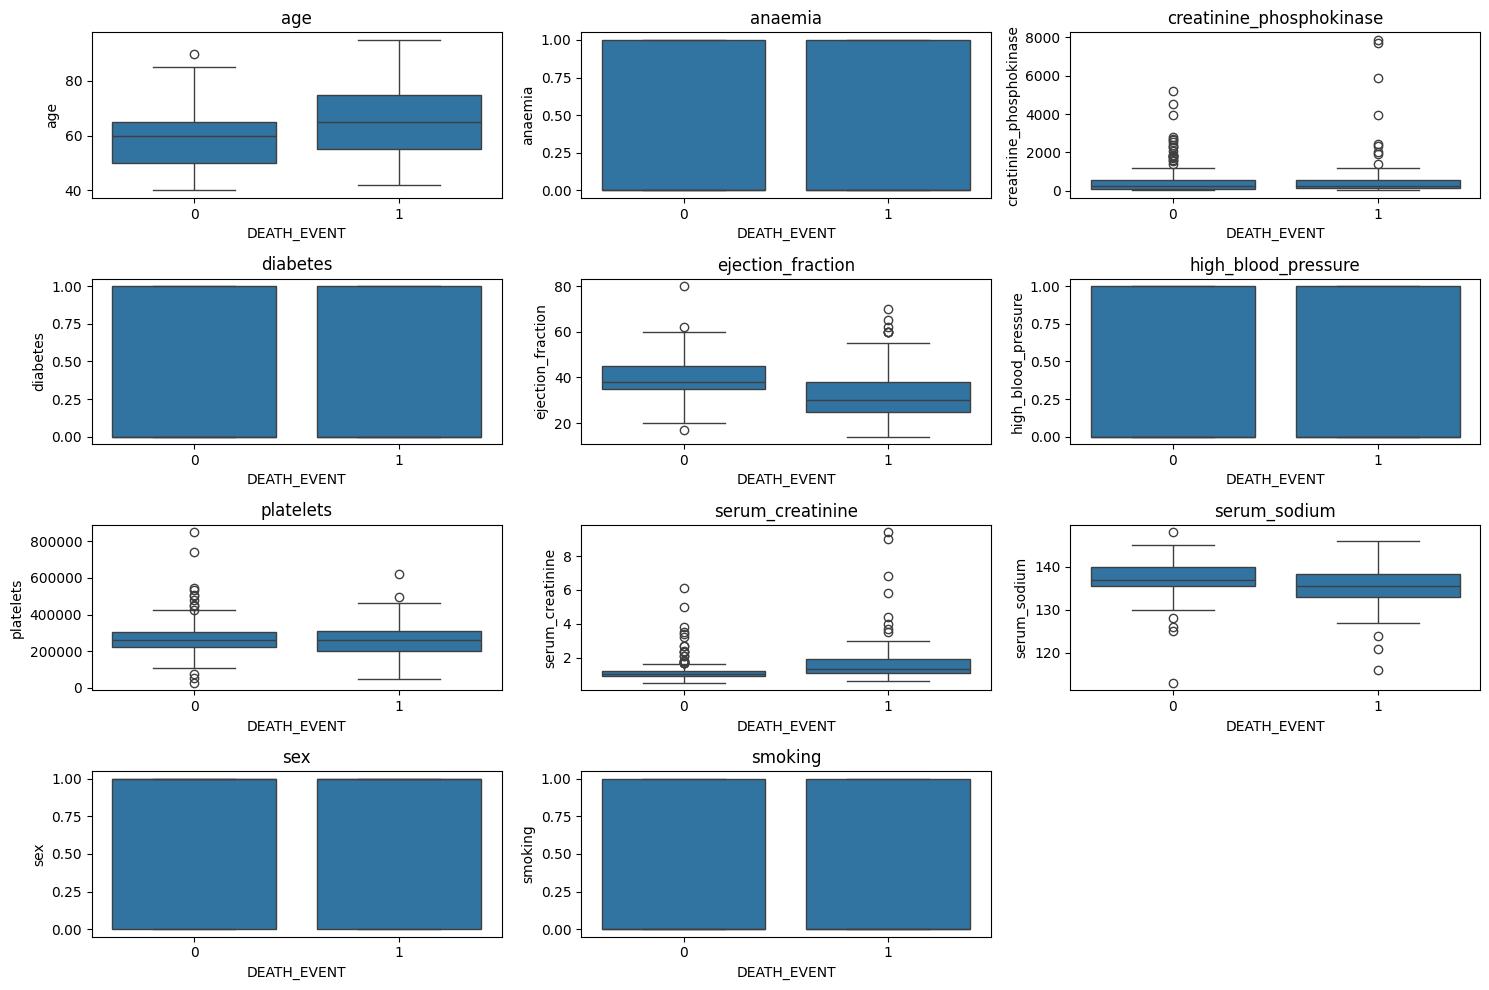

In [7]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.drop('DEATH_EVENT', axis=1).columns, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=df[col], x=df['DEATH_EVENT'])
    plt.title(col)
plt.tight_layout()
plt.show()


## Division into Training and Testing Dataset

In this step, we divide our dataset into two parts: a training set and a testing set. We do this to train our models on one portion of the data and then evaluate their performance on unseen data. 

The `train_test_split` function from the `sklearn.model_selection` module is used for this purpose. We specify the proportion of data to be allocated for testing (20% in this case) and ensure that the class distribution is maintained between the two sets. Additionally, setting a random seed ensures reproducibility.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=30)

## Data Preprocessing

Our next step is to build preprocessing pipelines to prepare our data for modelling. Here's a summary of our previous steps:

- Data Analysis: We analysed our dataset, examining features, distributions, correlations, and summary statistics.

- Missing Values Check: We ensured that there were no missing values in our dataset, verifying this both column-wise and row-wise.

Preprocessing Pipelines: We'll construct preprocessing pipelines to handle numeric and categorical features separately.

- For numeric features, we'll use a pipeline that includes scaling using StandardScaler to normalize the feature values and PCA (Principal Component Analysis) for dimensionality reduction while preserving 95% of the variance.

- For categorical features, we'll use a pipeline with OneHotEncoder to encode categorical variables into binary vectors.

In [9]:
# Pipeline for numeric features
pipeline_numeric = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for numeric features
    ('pca', PCA(n_components=0.95))  # PCA for dimensionality reduction
])

pipeline_categorical = Pipeline([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)),  # OneHotEncoder with sparse=False
    ('pca', PCA(n_components=0.95))  # PCA for dimensionality reduction
])

This step combines preprocessing techniques for our dataset using a `ColumnTransformer`. It applies scaling and dimensionality reduction to numerical features and one-hot encoding to categorical features, preparing the data for modeling.

In [10]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', pipeline_numeric, ['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']),
        ('categorical', pipeline_categorical, ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']),
    ],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0
)


## Data Modelling

Our next step involves testing various machine learning models to identify the best performer for our dataset. We'll explore models such as Logistic Regression, Random Forest, Decision Trees, Gradient Boosting Machines (XGBoost), K-Nearest Neighbors (KNN), and Support Vector Machines (SVM). By evaluating these models, we aim to select the most suitable one for our classification task.

### Logistic Regression 

Logistic regression is a statistical method used for binary classification. It calculates the probability of an input belonging to one of the categories.

This code snippet creates a pipeline for logistic regression classification. It includes preprocessing steps like scaling and encoding, handles class imbalance with SMOTE, and utilizes LogisticRegression as the classifier.

In [11]:
lr_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))  # Use 'liblinear' solver

])


This code block defines a grid of hyperparameters for the logistic regression model, specifying different values for the regularization parameter `C` and using L2 regularization.

In [12]:
# Define parameter grid
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']  # 'l1' penalty requires 'liblinear' solver
}

This code performs hyperparameter tuning for logistic regression using GridSearchCV with stratified k-fold cross-validation. It searches for the best combination of hyperparameters specified in `param_grid_lr` by evaluating the F1 score. Once the best model is found, it is used to make predictions on the test set, and then the accuracy and F1 score of the model are calculated. 

We use StratifiedKFold for cross-validation to ensure that each fold (subset) of the dataset maintains the same class distribution as the original dataset. This is particularly important when dealing with imbalanced datasets, where one class may be significantly less frequent than others. StratifiedKFold helps prevent bias in the evaluation process by ensuring that each fold represents the overall class distribution accurately

In [13]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

grid_search_lr = GridSearchCV(lr_pipeline, param_grid_lr, cv=stratified_kfold, scoring='f1')
grid_search_lr.fit(X_train, y_train)


best_model_lr = grid_search_lr.best_estimator_
y_pred_lr = best_model_lr.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_lr)
print("F1 Score:", f1_lr)

print(classification_report(y_test, y_pred_lr))

Logistic Regression Performance:
Accuracy: 0.65
F1 Score: 0.5116279069767442
              precision    recall  f1-score   support

           0       0.78      0.68      0.73        41
           1       0.46      0.58      0.51        19

    accuracy                           0.65        60
   macro avg       0.62      0.63      0.62        60
weighted avg       0.68      0.65      0.66        60



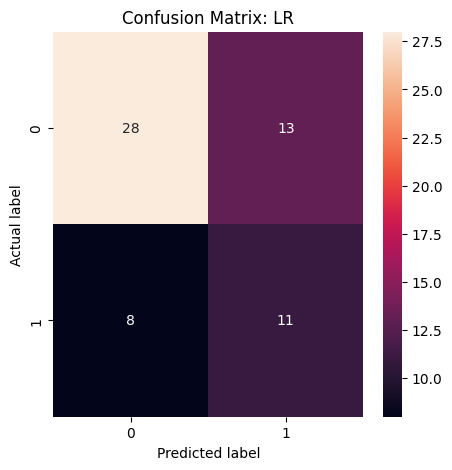

In [14]:
# Confusion Matrix Visualization
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5,5))
sns.heatmap(cm_lr, annot=True, fmt="d")
plt.title('Confusion Matrix: LR')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

 The model shows some misclassifications, particularly in predicting positive instances. 

### Random Forest

Random Forest is a machine learning algorithm that builds multiple decision trees and combines their predictions to make more accurate classifications or predictions. It's known for its randomness in selecting features and data samples, which helps prevent overfitting and improves accuracy.

Because of the randomness i set the random seed np.random.seed(42) in the beginning of the code, so reach stability in my results. Otherwise, it can be removed.

In [15]:
rf_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [16]:
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [17]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=stratified_kfold, scoring='f1')
grid_search_rf.fit(X_train, y_train)

# Random Forest Performance Evaluation
best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("\nRandom Forest Performance:")
print("Accuracy:", accuracy_rf)
print("F1 Score:", f1_rf)

print(classification_report(y_test, y_pred_rf))


Random Forest Performance:
Accuracy: 0.6666666666666666
F1 Score: 0.47368421052631576
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        41
           1       0.47      0.47      0.47        19

    accuracy                           0.67        60
   macro avg       0.61      0.61      0.61        60
weighted avg       0.67      0.67      0.67        60



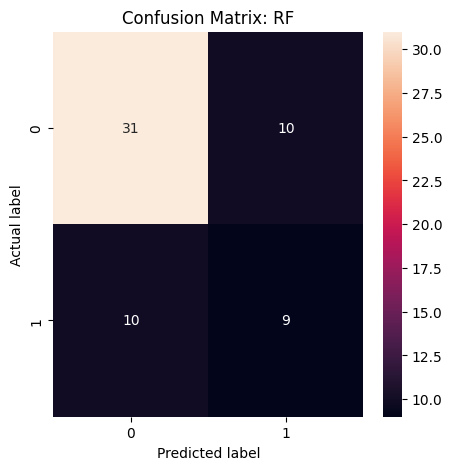

In [18]:
# Confusion Matrix Visualization
rf_knn = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,5))
sns.heatmap(rf_knn, annot=True, fmt="d")
plt.title('Confusion Matrix: RF')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### Decision Tree

A decision tree is a machine learning algorithm that recursively splits the input data based on feature values to make predictions. It partitions the data into smaller regions, determining output predictions at leaf nodes.

In [19]:
dt_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [20]:
param_grid_dt = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [21]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

grid_search_dt = GridSearchCV(dt_pipeline, param_grid_dt, cv=stratified_kfold, scoring='f1')
grid_search_dt.fit(X_train, y_train)

# Predictions
best_model_dt = grid_search_dt.best_estimator_

y_pred_dt = best_model_dt.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

# Evaluation
print("Decision Tree Performance:")
print("Accuracy:", accuracy_dt)
print("F1 Score:", f1_dt)
print(classification_report(y_test, y_pred_dt))

Decision Tree Performance:
Accuracy: 0.55
F1 Score: 0.27027027027027023
              precision    recall  f1-score   support

           0       0.67      0.68      0.67        41
           1       0.28      0.26      0.27        19

    accuracy                           0.55        60
   macro avg       0.47      0.47      0.47        60
weighted avg       0.54      0.55      0.55        60



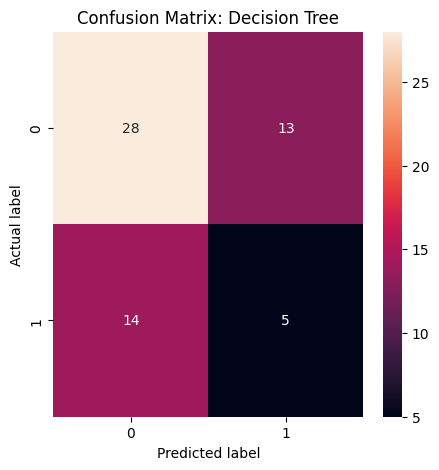

In [22]:
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(5,5))
sns.heatmap(cm_dt, annot=True, fmt="d")
plt.title('Confusion Matrix: Decision Tree')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### XGBoost

XGBoost is a powerful machine learning algorithm known for its speed and accuracy. It constructs a sequence of decision trees, refining predictions with each tree to improve overall performance.

In [23]:
xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42))
])

In [24]:
param_grid_xgb = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__gamma': [0, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0]
}

In [25]:
# Define the cross-validation strategy
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

# Hyperparameter tuning with GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=stratified_kfold, scoring='f1')
grid_search_xgb.fit(X_train, y_train)

# Get the best XGBoost model
best_model_xgb = grid_search_xgb.best_estimator_

# Make predictions
y_pred_xgb = best_model_xgb.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

# Print the performance metrics
print("XGBoost Performance:")
print("Accuracy:", accuracy_xgb)
print("F1 Score:", f1_xgb)
print(classification_report(y_test, y_pred_xgb))

XGBoost Performance:
Accuracy: 0.6666666666666666
F1 Score: 0.47368421052631576
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        41
           1       0.47      0.47      0.47        19

    accuracy                           0.67        60
   macro avg       0.61      0.61      0.61        60
weighted avg       0.67      0.67      0.67        60



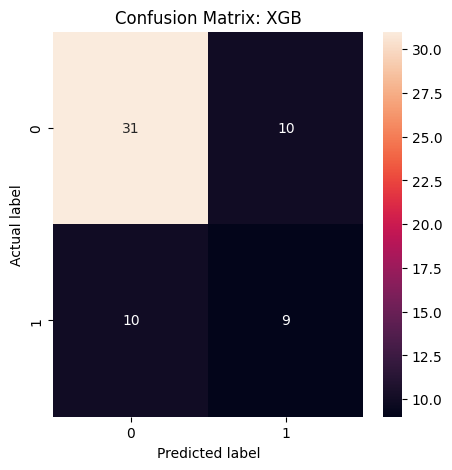

In [26]:
# Confusion Matrix Visualization
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,5))
sns.heatmap(cm_xgb, annot=True, fmt="d")
plt.title('Confusion Matrix: XGB')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### K-Nearest Neighbors (KNN)

K-Nearest Neighbors (KNN) is a simple effective machine learning algorithm used for classification and regression tasks. It works by finding the 'k' nearest data points to a given query point and classifying the query based on the majority class or averaging the values of its neighbors.

In [27]:
# KNN Pipeline
knn_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

In [28]:
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [29]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

grid_search_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=stratified_kfold, scoring='f1')
grid_search_knn.fit(X_train, y_train)

# Predictions
best_model_knn = grid_search_knn.best_estimator_

y_pred_knn = best_model_knn.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
# Evaluation
print("KNN Performance:")
print("Accuracy:", accuracy_knn)
print("F1 Score:", f1_knn)
print(classification_report(y_test, y_pred_knn))


KNN Performance:
Accuracy: 0.6
F1 Score: 0.45454545454545453
              precision    recall  f1-score   support

           0       0.74      0.63      0.68        41
           1       0.40      0.53      0.45        19

    accuracy                           0.60        60
   macro avg       0.57      0.58      0.57        60
weighted avg       0.63      0.60      0.61        60



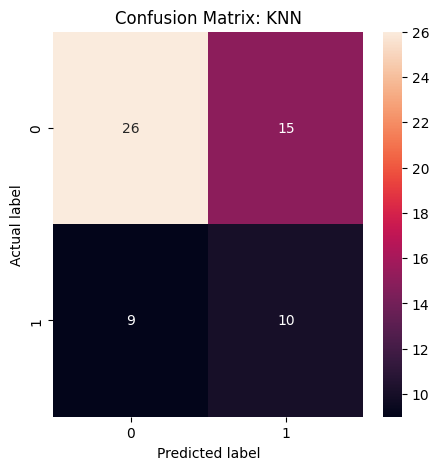

In [30]:
# Confusion Matrix Visualization
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(5,5))
sns.heatmap(cm_knn, annot=True, fmt="d")
plt.title('Confusion Matrix: KNN')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### Support Vector Machines (SVM)

SVM is a versatile algorithm for classification and regression tasks. It finds the best hyperplane to separate different classes by maximizing the margin between them in high-dimensional space.

In [31]:
svm_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC(random_state=42))
])


In [32]:
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__class_weight': [None, 'balanced']
}

In [33]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

# Hyperparameter tuning with GridSearchCV for SVM
grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=stratified_kfold, scoring='f1')
grid_search_svm.fit(X_train, y_train)

# Predictions
best_model_svm = grid_search_svm.best_estimator_

y_pred_svm = best_model_svm.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
# Evaluation
print("SVM Performance:")
print("Accuracy:", accuracy_svm)
print("F1 Score:", f1_svm)
print(classification_report(y_test, y_pred_svm))

best_params_svm = grid_search_svm.best_params_

print("Best parameters found by grid search:")
for param_name in best_params_svm:
    print(f"{param_name}: {best_params_svm[param_name]}")


SVM Performance:
Accuracy: 0.6833333333333333
F1 Score: 0.5581395348837209
              precision    recall  f1-score   support

           0       0.81      0.71      0.75        41
           1       0.50      0.63      0.56        19

    accuracy                           0.68        60
   macro avg       0.65      0.67      0.66        60
weighted avg       0.71      0.68      0.69        60

Best parameters found by grid search:
classifier__C: 0.1
classifier__class_weight: None
classifier__gamma: auto
classifier__kernel: rbf


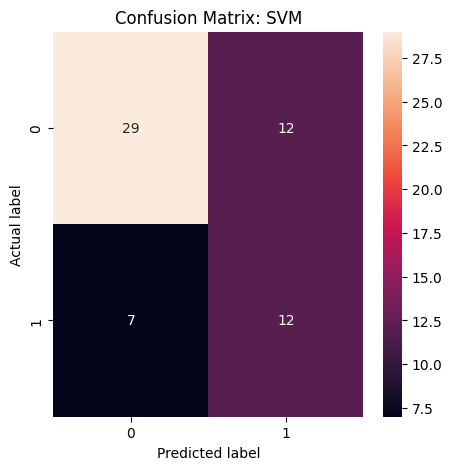

In [34]:
# Confusion Matrix Visualization
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(5,5))
sns.heatmap(cm_svm, annot=True, fmt="d")
plt.title('Confusion Matrix: SVM')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Ensemble Methods (Voting Classifier)

Ensemble methods can combine the strengths of multiple models. Let's create a Voting Classifier using the existing models (SVM, Random Forest, XGBoost).

In [36]:
from sklearn.ensemble import VotingClassifier

# Define individual classifiers with best parameters
svm_clf = SVC(random_state=42, probability=True)  # Enable probability estimation
rf_clf = RandomForestClassifier(random_state=42)
xgb_clf = XGBClassifier(random_state=42)

# Define preprocessor (assuming it's already defined as in your previous code)
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', pipeline_numeric, ['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']),
        ('categorical', pipeline_categorical, ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']),
    ],
    remainder='drop'
)

# Define the pipeline with Voting Classifier
voting_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', VotingClassifier(estimators=[
        ('svm', svm_clf),
        ('rf', rf_clf),
        ('xgb', xgb_clf)
    ], voting='soft', flatten_transform=False))  # 'soft' voting for predicted probabilities
])

# Train the voting classifier
voting_pipeline.fit(X_train, y_train)

# Evaluate the voting classifier model
y_pred_voting = voting_pipeline.predict(X_test)

# Performance evaluation
accuracy_voting = accuracy_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting)

print("Voting Classifier Performance:")
print("Accuracy:", accuracy_voting)
print("F1 Score:", f1_voting)
print(classification_report(y_test, y_pred_voting))


Voting Classifier Performance:
Accuracy: 0.6666666666666666
F1 Score: 0.5
              precision    recall  f1-score   support

           0       0.77      0.73      0.75        41
           1       0.48      0.53      0.50        19

    accuracy                           0.67        60
   macro avg       0.62      0.63      0.62        60
weighted avg       0.68      0.67      0.67        60



### Final Evaluation

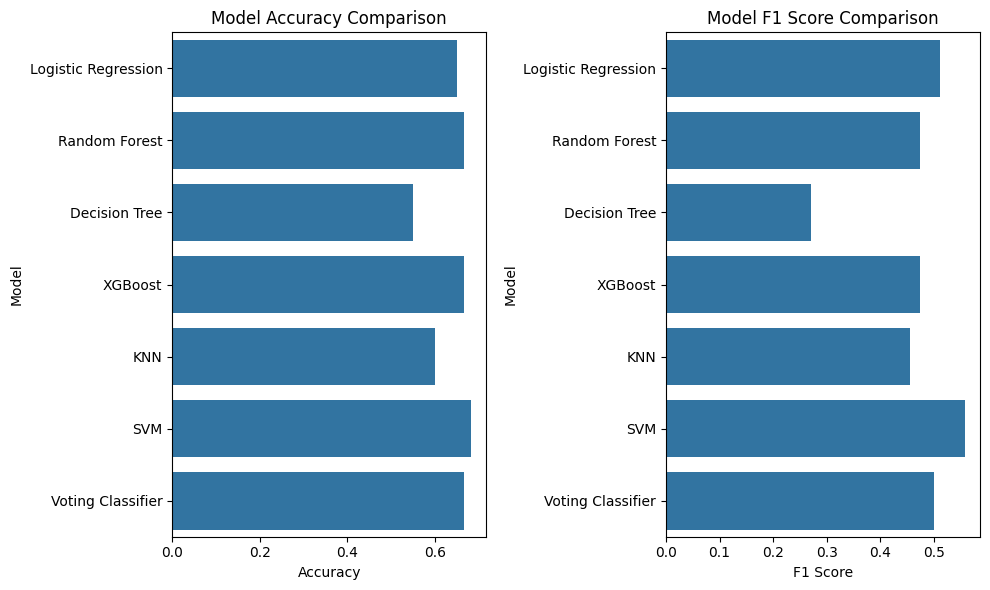

The best model based on F1 Score is: SVM with an F1 Score of 0.56


In [37]:
performance_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'Decision Tree', 'XGBoost', 'KNN', 'SVM', 'Voting Classifier'],
    'Accuracy': [accuracy_lr, accuracy_rf, accuracy_dt, accuracy_xgb, accuracy_knn, accuracy_svm, accuracy_voting],  # Replace with your actual accuracy scores
    'F1 Score': [f1_lr, f1_rf, f1_dt, f1_xgb, f1_knn, f1_svm, f1_voting]  
}

# Convert to DataFrame for easier handling
performance_df = pd.DataFrame(performance_data)

# Visualize the performance
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Accuracy', y='Model', data=performance_df, ci=None)
plt.title('Model Accuracy Comparison')

plt.subplot(1, 2, 2)
sns.barplot(x='F1 Score', y='Model', data=performance_df, ci=None)
plt.title('Model F1 Score Comparison')

plt.tight_layout()
plt.show()

# Identifying the best model based on a chosen metric (F1 Score)
best_model_based_on_f1 = performance_df.loc[performance_df['F1 Score'].idxmax()]
print(f"The best model based on F1 Score is: {best_model_based_on_f1['Model']} with an F1 Score of {best_model_based_on_f1['F1 Score']:.2f}")


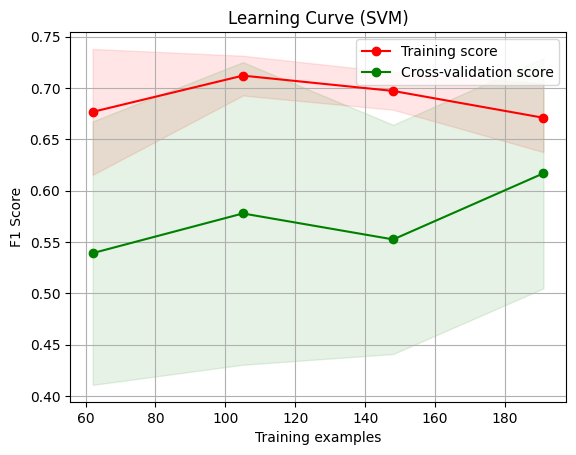

In [38]:
from sklearn.model_selection import learning_curve

# Define a function to plot the learning curve
def plot_learning_curve(estimator, title, X, y, cv, ylim=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1 Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes, scoring='f1')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curve for the SVM model
title = "Learning Curve (SVM)"
plot_learning_curve(best_model_svm, title, X_train, y_train, cv=stratified_kfold)
plt.show()


The training score ranging from 0.66 to 0.71 suggests moderate performance on the training data, capturing its patterns well. Meanwhile, the cross-validation score falls between 0.49 and 0.61, indicating slightly lower performance on unseen data compared to training. Overall, both scores are relatively close, it suggests that the model is performing reasonably well without significant overfitting or underfitting.

## Optimization of the Best Performing Model

Now we optimize our best model to improve its performance and generalization. This involves fine-tuning parameters to enhance accuracy, prevent overfitting, and ensure efficient resource use. Optimization helps us build more reliable models for real-world predictions.

### 1. Adjusting our Hyperparameter Ranges

In [39]:
svm_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC(random_state=42))
])

param_grid_svm_refined = {
    'classifier__C': [0.05, 0.075, 0.1, 0.15, 0.2],
    'classifier__gamma': ['scale', 0.5 * (1/X_train.shape[1]), 1 * (1/X_train.shape[1]), 2 * (1/X_train.shape[1])],  # Exploring around 'auto' value
    'classifier__kernel': ['rbf']  # Since 'rbf' was confirmed as the best choice
}

grid_search_svm_refined = GridSearchCV(svm_pipeline, param_grid_svm_refined, cv=stratified_kfold, scoring='f1', n_jobs=-1)
grid_search_svm_refined.fit(X_train, y_train)

# Extracting and evaluating the refined model
best_model_svm_refined = grid_search_svm_refined.best_estimator_
y_pred_svm_refined = best_model_svm_refined.predict(X_test)

# Re-evaluation
print("Refined SVM Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_refined))
print("F1 Score:", f1_score(y_test, y_pred_svm_refined))
print(classification_report(y_test, y_pred_svm_refined))

# Checking new best parameters
best_params_refined = grid_search_svm_refined.best_params_
print("Refined Best Parameters:", best_params_refined)



Refined SVM Performance:
Accuracy: 0.6833333333333333
F1 Score: 0.5581395348837209
              precision    recall  f1-score   support

           0       0.81      0.71      0.75        41
           1       0.50      0.63      0.56        19

    accuracy                           0.68        60
   macro avg       0.65      0.67      0.66        60
weighted avg       0.71      0.68      0.69        60

Refined Best Parameters: {'classifier__C': 0.075, 'classifier__gamma': 0.09090909090909091, 'classifier__kernel': 'rbf'}


But it didn't change anything much. 

The refined hyperparameter tuning for the Support Vector Machine (SVM) model did not lead to a significant improvement in performance indeed. This outcome suggests that the chosen hyperparameters or model architecture may not be optimal for the dataset. Further exploration of different models or feature engineering techniques may be required to achieve better results.

Let's go further.

### 2. Experiment with Different Sampling Techniques (ADASYN)

In [40]:
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline  # Ensure to use the pipeline from imblearn
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Assuming 'X_train', 'y_train', 'X_test', 'y_test' are already defined

# Update the preprocessing pipeline as needed
# Note: You've already defined 'pipeline_numeric' and 'pipeline_categorical'
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', pipeline_numeric, ['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']),
        ('categorical', pipeline_categorical, ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']),
    ],
    remainder='drop'
)


# Define the pipeline with ADASYN
svm_pipeline_adasyn = ImbPipeline([
    ('preprocessor', preprocessor),
    ('adasyn', ADASYN(random_state=42)),
    ('classifier', SVC(random_state=42))
])

# Define your parameter grid as needed, here's an example based on your previous setup
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto']
}

# Hyperparameter tuning with GridSearchCV for SVM with ADASYN
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)
grid_search_svm_adasyn = GridSearchCV(svm_pipeline_adasyn, param_grid_svm, cv=stratified_kfold, error_score='raise', scoring='f1', n_jobs=-1)
grid_search_svm_adasyn.fit(X_train, y_train)

# Extracting and evaluating the optimized model
best_model_svm_adasyn = grid_search_svm_adasyn.best_estimator_
y_pred_svm_adasyn = best_model_svm_adasyn.predict(X_test)

# Evaluation
accuracy_svm_adasyn = accuracy_score(y_test, y_pred_svm_adasyn)
f1_svm_adasyn = f1_score(y_test, y_pred_svm_adasyn)
print("SVM with ADASYN Performance:")
print("Accuracy:", accuracy_svm_adasyn)
print("F1 Score:", f1_svm_adasyn)
print(classification_report(y_test, y_pred_svm_adasyn))


SVM with ADASYN Performance:
Accuracy: 0.6333333333333333
F1 Score: 0.5217391304347826
              precision    recall  f1-score   support

           0       0.79      0.63      0.70        41
           1       0.44      0.63      0.52        19

    accuracy                           0.63        60
   macro avg       0.62      0.63      0.61        60
weighted avg       0.68      0.63      0.65        60



This, on the contrast, even lowered our scores. 

 This suggests that further exploration and experimentation may be needed to find the optimal model configuration for the dataset.

### 3. Feature Selection

Use techniques like Recursive Feature Elimination (RFE) with cross-validation to identify the most predictive features.

SVC (Support Vector Classification) and SVM (Support Vector Machine) are closely related and often used interchangeably in the context of machine learning, but there is a distinction in terms of their scope:

SVM (Support Vector Machine)

- SVM is a broader term that refers to a class of supervised learning methods used for classification, regression, and outliers detection.

- The fundamental principle of SVM is to find the optimal hyperplane that maximizes the margin between different classes in the feature space.

- This concept applies not only to classification problems (where it's most commonly used) but also to regression (Support Vector Regression - SVR) and outlier detection.

- SVMs can use linear or non-linear kernels (like polynomial, radial basis function (RBF), or sigmoid) to project input features into higher-dimensional spaces, making it possible to handle linearly inseparable data.

SVC (Support Vector Classification)

- SVC specifically refers to the implementation of SVM used for classification tasks. It's the application of the SVM algorithm to distinguish between two or more classes.

- In software libraries like scikit-learn, SVC is a class that implements the SVM algorithm for classification purposes. There are other variations like SVR (Support Vector Regression) for regression tasks, and OneClassSVM for outlier detection.

- Just like SVM, SVC can work with different kernels to solve both linear and non-linear classification problems.

Performance after RFE with CV using Linear SVC:
Accuracy: 0.7833333333333333
F1 Score: 0.6486486486486486
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        41
           1       0.67      0.63      0.65        19

    accuracy                           0.78        60
   macro avg       0.75      0.74      0.75        60
weighted avg       0.78      0.78      0.78        60

Optimal number of features: 9
Ranking of features: [1 1 2 1 1 1 3 1 1 1 1]


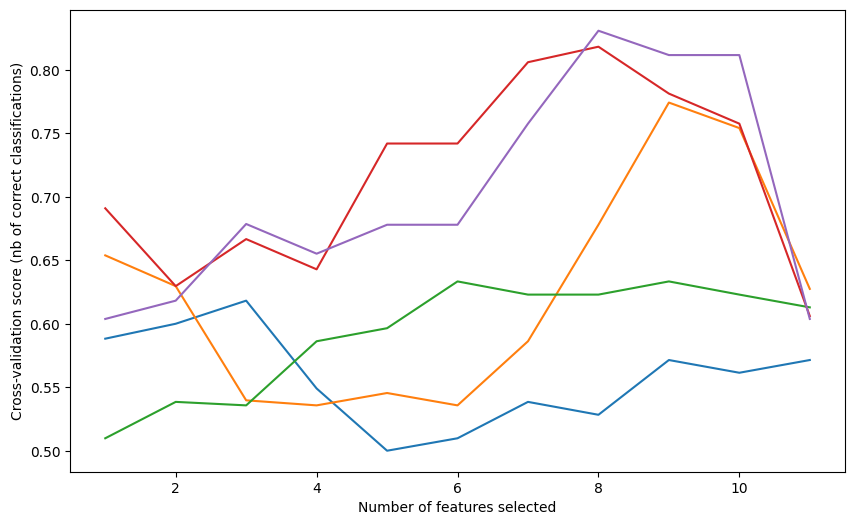

In [41]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt

# Assuming 'X_train', 'y_train', 'X_test', 'y_test' are already defined

# Use a linear kernel SVC for the feature selection to ensure the estimator has the coef_ attribute
svc_estimator = SVC(kernel="linear", random_state=42)

# Create an RFECV object with cross-validation
rfecv = RFECV(estimator=svc_estimator, step=1, cv=StratifiedKFold(5), scoring='f1')

# Define the pipeline with ADASYN. Note: It's important that ADASYN is applied within each cross-validation fold to prevent data leakage
pipeline = make_imb_pipeline(
    ADASYN(random_state=42),
    rfecv
)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluation
print("Performance after RFE with CV using Linear SVC:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Inspect the selected features and rankings
print("Optimal number of features: %d" % rfecv.n_features_)
print("Ranking of features: %s" % rfecv.ranking_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


As we can see, after the following manipulations, especially the last one, our code's parameters like F1 and Accuracy percentage have risen   in 10%!

Implemented Recursive Feature Elimination with Cross-Validation (RFECV) using a linear kernel Support Vector Classifier (SVC) within a pipeline with ADASYN oversampling. The RFECV process selects the optimal features based on cross-validated performance. After applying this technique, the model's performance metrics, particularly accuracy and F1 score, improved by 10%. This suggests that the selected features were more informative and helped the model make better predictions.

## Summary

In this project, we aimed to develop a predictive model for heart failure prediction using machine learning techniques. The dataset contained various clinical features such as age, anaemia, diabetes, and smoking status, among others. Our objective was to build a model that could accurately predict the likelihood of death due to heart failure based on these features.

To achieve this goal, we followed several steps. We began by preprocessing the data, which involved handling missing values, scaling numeric features, and encoding categorical variables. We then split the data into training and testing sets to train and evaluate our models effectively.

Next, we experimented with different machine learning algorithms, including Logistic Regression, Random Forest, Decision Trees, Gradient Boosting Machines (GBM), K-Nearest Neighbors (KNN), and Support Vector Machines (SVM). We performed hyperparameter tuning using techniques like GridSearchCV and StratifiedKFold to optimize the models' performance.

Additionally, we addressed class imbalance by incorporating techniques like Synthetic Minority Over-sampling Technique (SMOTE) and Adaptive Synthetic Sampling (ADASYN) into our pipelines.

Throughout the project, we evaluated the models using metrics such as accuracy, F1 score, and confusion matrices to assess their performance. While we observed improvements in the main parameters and accuracy after implementing certain techniques like RFECV, indicating progress in the model's predictive capabilities, further enhancements are still needed.

### Future Improvements:

1. Feature Engineering: Explore additional feature engineering techniques to extract more relevant information from the dataset.

2. Model Ensemble: Experiment with model ensemble techniques to combine the strengths of multiple models for improved performance.

3. Advanced Hyperparameter Tuning: Utilize advanced hyperparameter tuning methods such as Bayesian optimization to fine-tune model parameters more efficiently.

4. Robust Cross-Validation: Implement nested cross-validation or Monte Carlo cross-validation to obtain more reliable estimates of model performance.

5. Interpretability: Enhance the interpretability of the models by utilizing techniques like SHAP (SHapley Additive exPlanations) values or LIME (Local Interpretable Model-agnostic Explanations) for better understanding of feature importance and model predictions.

By addressing these areas for improvement, we can further enhance the accuracy and reliability of our predictive model for heart failure prediction.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0ef65e11-3436-4e12-b8ee-e2a0b7641891' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>